In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# IMPORT MODULES
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Input, Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.models import Model
from keras.applications import InceptionResNetV2


In [4]:
# 設定earlystop條件
estop = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

# 設定模型儲存條件
checkpoint = ModelCheckpoint('InceptionResNetV2_checkpoint_v2.h5', verbose=1,
                          monitor='val_loss', save_best_only=True,
                          mode='min')

# 設定lr降低條件(0.001 → 0.0005 → 0.00025 → 0.000125 → 0.0001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                           patience=5, mode='min', verbose=1,
                           min_lr=1e-5)

In [5]:
import random
import pandas as pd
import glob

Naturel= glob.glob("/content/drive/MyDrive/第三版資料集/上衣（棉質上衣、T恤、套衫、罩衫、針織衫、襯衫）/Naturel/*")
random.shuffle(Naturel)
Straight= glob.glob("/content/drive/MyDrive/第三版資料集/上衣（棉質上衣、T恤、套衫、罩衫、針織衫、襯衫）/Straight/*")
random.shuffle(Straight)
Wave= glob.glob("/content/drive/MyDrive/第三版資料集/上衣（棉質上衣、T恤、套衫、罩衫、針織衫、襯衫）/Wave/*")
random.shuffle(Wave)
print(len(Naturel), len(Straight), len(Wave))
train = pd.DataFrame({
    "filename": Naturel[:262] + Straight[:140] + Wave[:265],
    "class": [0] * 262 + [1] * 140 + [2] * 265
})

validate = pd.DataFrame({
    "filename": Naturel[262:277] + Straight[140:148] + Wave[265:280],
    "class": [0] * 15 + [1] * 8 + [2] * 15
})

test = pd.DataFrame({
    "filename": Naturel[277:292] + Straight[148:156] + Wave[280:295],
    "class": [0] * 15 + [1] * 8 + [2] * 15
})
train

292 156 295


,filename,class
0,/content/drive/MyDrive/第三版資料集/上衣（棉質上衣、T恤、套衫、罩衫...,0
1,/content/drive/MyDrive/第三版資料集/上衣（棉質上衣、T恤、套衫、罩衫...,0
2,/content/drive/MyDrive/第三版資料集/上衣（棉質上衣、T恤、套衫、罩衫...,0
3,/content/drive/MyDrive/第三版資料集/上衣（棉質上衣、T恤、套衫、罩衫...,0
4,/content/drive/MyDrive/第三版資料集/上衣（棉質上衣、T恤、套衫、罩衫...,0
...,...,...
662,/content/drive/MyDrive/第三版資料集/上衣（棉質上衣、T恤、套衫、罩衫...,2
663,/content/drive/MyDrive/第三版資料集/上衣（棉質上衣、T恤、套衫、罩衫...,2
664,/content/drive/MyDrive/第三版資料集/上衣（棉質上衣、T恤、套衫、罩衫...,2
665,/content/drive/MyDrive/第三版資料集/上衣（棉質上衣、T恤、套衫、罩衫...,2


Found 667 validated image filenames.
Found 38 validated image filenames.
Found 38 validated image filenames.


(32, 80, 80, 3)


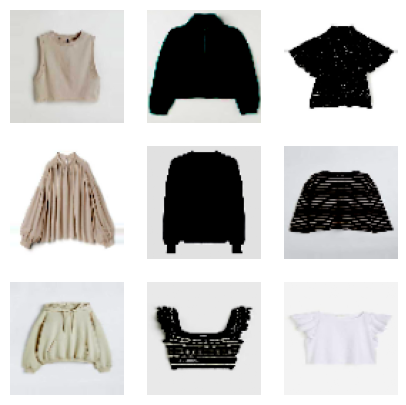

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input 

# from tensorflow.keras.applications.vgg16 import preprocess_input
# 資料增強: zoom:放大(1.2) shear:偏斜(0.2) 水平翻轉


train_datagen = ImageDataGenerator(
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True, preprocessing_function=preprocess_input
)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

training_set = train_datagen.flow_from_dataframe(
    train,
    ".",
    target_size=(80, 80),
    batch_size=32,
    class_mode="raw")  # <- Change this to 'categorical'
validate_set = test_datagen.flow_from_dataframe(
    validate,
    ".",
    target_size=(80, 80),
    batch_size=32,
    class_mode="raw")  # <- Change this to 'categorical'
test_set = test_datagen.flow_from_dataframe(
    test,
    ".",
    target_size=(80, 80),
    batch_size=32,
    class_mode="raw")  # <- Change this to 'categorical'

import matplotlib.pyplot as plt
# __next__: (圖片, 答案)
batch = training_set.__next__()[0]
print(batch.shape)
plt.figure(figsize=(5, 5))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(batch[i])
    plt.axis("off")



In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications import InceptionResNetV2

inception_resnet_v2 = InceptionResNetV2(include_top=False, input_shape=(80, 80, 3))

# Freeze layers up to mixed_6a
for layer in inception_resnet_v2.layers[:781]:
    layer.trainable = False

# Add new layers
x = BatchNormalization()(inception_resnet_v2.output)
x = GlobalAveragePooling2D()(x)
x = Dense(3, activation="softmax")(x)

# Create new model
model = Model(inputs=inception_resnet_v2.input, outputs=x)

# Print model summary
model.summary()

219055592/219055592 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 39, 39, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 39, 39, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)   

In [8]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(),
       optimizer="adam",
       metrics=["accuracy"])

In [9]:
import datetime
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import CSVLogger

callbacks = [CSVLogger("/content/drive/MyDrive/InceptionResNetV2/Top/Top_training_log.csv"),
       EarlyStopping(patience=10, restore_best_weights=True),
       ModelCheckpoint("/content/drive/MyDrive/InceptionResNetV2/Top/Top_best.h5", save_best_only=True),
    # 檢查test資料, 如果我10次都沒有表現更好, 停
    
]

# 不想要進度條, verbose=2
model.fit(training_set,
     epochs=100,
     validation_data=validate_set,
     callbacks=callbacks,
     verbose=2)

Epoch 1/100
21/21 - 123s - loss: 1.1658 - accuracy: 0.4963 - val_loss: 1.0775 - val_accuracy: 0.4211 - 123s/epoch - 6s/step
Epoch 2/100
21/21 - 6s - loss: 0.8442 - accuracy: 0.6312 - val_loss: 1.0187 - val_accuracy: 0.5263 - 6s/epoch - 308ms/step
Epoch 3/100
21/21 - 7s - loss: 0.6913 - accuracy: 0.7136 - val_loss: 0.9400 - val_accuracy: 0.5789 - 7s/epoch - 344ms/step
Epoch 4/100
21/21 - 6s - loss: 0.6425 - accuracy: 0.7151 - val_loss: 0.8804 - val_accuracy: 0.6842 - 6s/epoch - 297ms/step
Epoch 5/100
21/21 - 4s - loss: 0.6427 - accuracy: 0.7271 - val_loss: 0.8905 - val_accuracy: 0.6316 - 4s/epoch - 199ms/step
Epoch 6/100
21/21 - 5s - loss: 0.5809 - accuracy: 0.7721 - val_loss: 0.9240 - val_accuracy: 0.5789 - 5s/epoch - 217ms/step
Epoch 7/100
21/21 - 5s - loss: 0.5707 - accuracy: 0.7706 - val_loss: 0.9877 - val_accuracy: 0.5789 - 5s/epoch - 240ms/step
Epoch 8/100
21/21 - 4s - loss: 0.5139 - accuracy: 0.7721 - val_loss: 0.9308 - val_accuracy: 0.5789 - 4s/epoch - 191ms/step
Epoch 9/100
21/

In [10]:
from tensorflow.keras.models import load_model
model= load_model("/content/drive/MyDrive/InceptionResNetV2/Top/Top_best.h5")

In [11]:
model.evaluate(test_set)

2/2 [==============================] - 4s 944ms/step - loss: 0.5585 - accuracy: 0.7895


[0.5584511756896973, 0.7894737124443054]

In [12]:
model.predict(test_set)

2/2 [==============================] - 3s 54ms/step


array([[4.03602242e-01, 5.92878699e-01, 3.51906870e-03],
       [9.91037726e-01, 8.90176184e-03, 6.04775814e-05],
       [1.69875566e-02, 1.44916922e-01, 8.38095546e-01],
       [3.06731582e-01, 2.63643146e-01, 4.29625243e-01],
       [1.31434873e-01, 5.90989552e-02, 8.09466183e-01],
       [5.16561605e-03, 1.51296740e-03, 9.93321359e-01],
       [1.47375852e-01, 2.17928514e-01, 6.34695649e-01],
       [5.67539096e-01, 1.36167452e-01, 2.96293467e-01],
       [5.92891216e-01, 1.58415005e-01, 2.48693794e-01],
       [6.56283200e-01, 3.29079986e-01, 1.46368444e-02],
       [2.33731586e-02, 1.37790889e-02, 9.62847769e-01],
       [1.08084030e-01, 7.09312141e-01, 1.82603776e-01],
       [4.61321115e-01, 6.73494413e-02, 4.71329540e-01],
       [7.29711652e-01, 4.40213457e-02, 2.26267025e-01],
       [2.58809049e-02, 9.54559386e-01, 1.95596963e-02],
       [2.87896633e-01, 3.45238835e-01, 3.66864532e-01],
       [2.47644279e-02, 5.79276308e-02, 9.17307973e-01],
       [2.29652256e-01, 7.21210

In [13]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
def getdata(df):
  img_org, img_preprocess, target = [], [], []
  for fn, c in zip(df["filename"], df["class"]):
    img = load_img(fn, target_size=(80, 80, 3))
    img_org.append(img)
    img_np = np.array(img)
    img = preprocess_input(img_np)
    img_preprocess.append(img)
    target.append(c)
  return np.array(img_org), np.array(img_preprocess), np.array(target)
img_org, x_test, y_test = getdata(test)
print(img_org.shape)
print(x_test.shape)
print(y_test.shape)

(38,)
(38, 80, 80, 3)
(38,)


<ipython-input-13-f435574e71a8>:12: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array(img_org), np.array(img_preprocess), np.array(target)
<ipython-input-13-f435574e71a8>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(img_org), np.array(img_preprocess), np.array(target)


In [14]:
pre = model.predict(x_test).argmax(axis=-1)
pre
     

2/2 [==============================] - 4s 44ms/step


array([0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 2, 1, 1, 1, 0, 2,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2])

In [15]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [16]:
idx = np.nonzero(pre != y_test)[0]
idx

array([ 3,  4,  5, 13, 16, 20, 21, 34])

In [17]:
from sklearn.metrics import confusion_matrix
import pandas as pd
cm = confusion_matrix(y_test, pre)
pd.DataFrame(cm, columns=["Naturel(P)", "Straight(P)", "Wave(P)"], index=["Naturel(T)", "Straight(T)", "Wave(T)"])
     

,Naturel(P),Straight(P),Wave(P)
Naturel(T),11,1,3
Straight(T),1,5,2
Wave(T),1,0,14


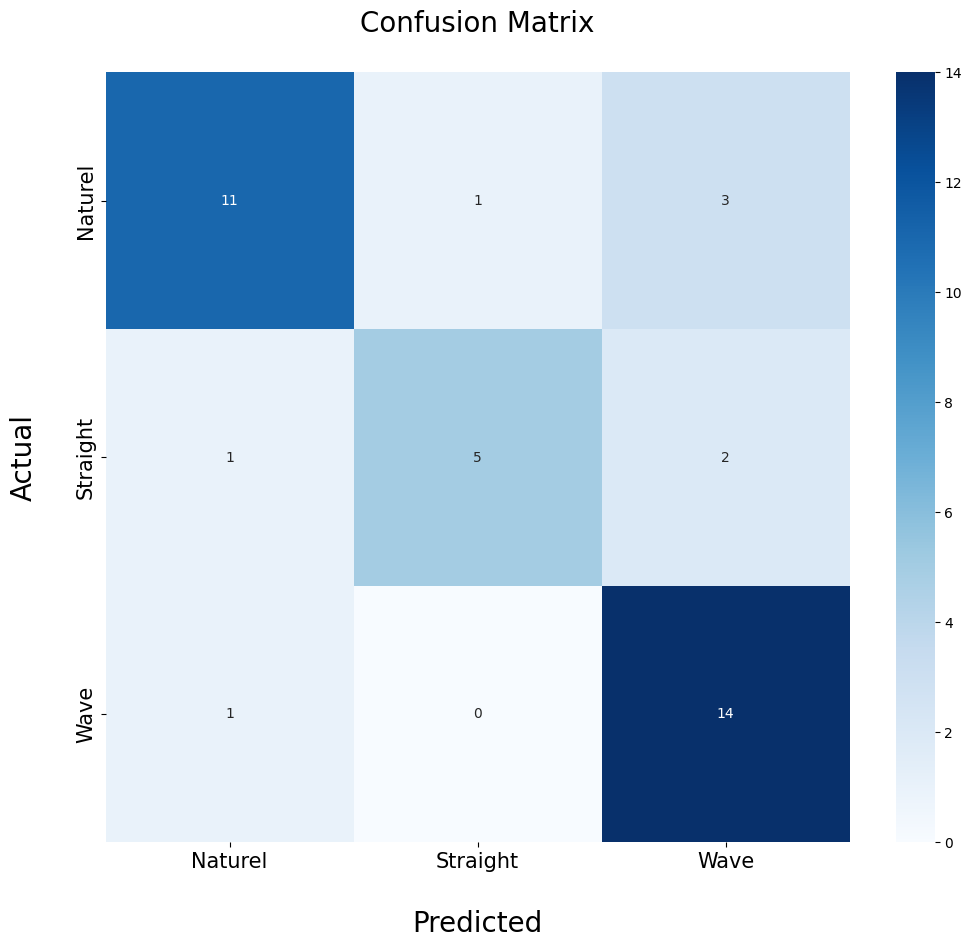

In [18]:
# imports
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

cm = confusion_matrix(y_test, pre)

plt.figure(figsize=(12,10))

# Using Seaborn heatmap to create the plot
fx = sns.heatmap(cm, annot=True, cmap=plt.cm.Blues)

# labels the title and x, y axis of plot
fx.set_title('Confusion Matrix\n', fontsize=20);
fx.set_xlabel('\nPredicted', fontsize=20)
fx.set_ylabel('Actual\n', fontsize=20);

# labels the boxes
fx.xaxis.set_ticklabels(["Naturel", "Straight", "Wave"], fontsize=15)
fx.yaxis.set_ticklabels(["Naturel", "Straight", "Wave"], fontsize=15)
plt.savefig("/content/drive/MyDrive/InceptionResNetV2/Top/Top_confution_matrix.jpg")
plt.show()

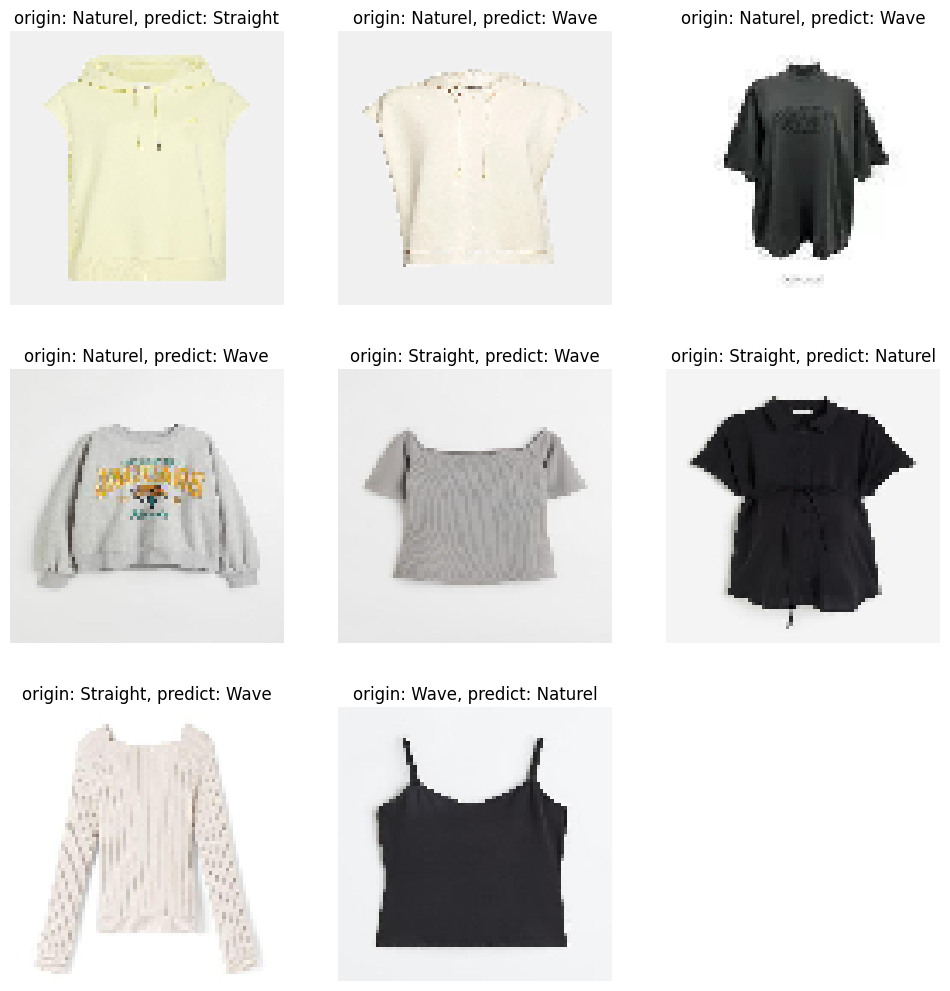

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
trans = ["Naturel", "Straight", "Wave"]
err_img = img_org[idx]
err_y = y_test[idx]
err_pre = pre[idx]
rows = 7
cols = 3
plt.figure(figsize=(12, 30))
for i in range(len(err_img)):
    plt.subplot(rows, cols, i+1)
    t = f"origin: {trans[err_y[i]]}, predict: {trans[err_pre[i]]}"
    plt.title(t)
    plt.axis("off")
    img = err_img[i]
    img_np = np.array(img)
    plt.imshow(img_np)
     